# Processo Seletivo: Cientista de Dados Júnior do Clube da Aposta

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Pre-processamento dos dados
from sklearn.preprocessing import LabelEncoder

# Modelo
from sklearn.svm import SVC

# Metricas
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score, average='weighted')

In [2]:
df = pd.read_json('base-dados-clube-da-aposta.json')

# Sugestão de ordens para as colunas
ordens_coluna = ['home_name', 'away_name', 'home_score', 'away_score', 'final_result', 'time', 
                 'home_pos', 'away_pos', 'round', 'home_last5all_home', 'home_last5all_home_win', 
                 'home_last5all_home_draw', 'home_last5all_home_lose', 'away_last5all_away', 
                 'away_last5all_away_win', 'away_last5all_away_draw', 'away_last5all_away_lose', 
                 'last5all_home_away_dif', 'fifa_home_ova', 'fifa_home_att', 'fifa_home_mid', 
                 'fifa_home_def', 'fifa_away_ova', 'fifa_away_att', 'fifa_away_mid', 'fifa_away_def', 
                 'elo_home_score', 'elo_away_score', 'tfm_value_home', 'tfm_value_away']

df = df[ordens_coluna]

# Modificando os nomes dos resultados finais
fr = dict(H='Mandante', D='Empate', A='Visitante')
df['final_result'] = df['final_result'].apply(lambda x: fr[x])

df.head()

,home_name,away_name,home_score,away_score,final_result,time,home_pos,away_pos,round,home_last5all_home,...,fifa_home_mid,fifa_home_def,fifa_away_ova,fifa_away_att,fifa_away_mid,fifa_away_def,elo_home_score,elo_away_score,tfm_value_home,tfm_value_away
0,FC Porto,Nacional,3,1,Mandante,1546895700,1,11,16,9,...,81,80,70,70,70,69,1813.906738,1392.986084,2.779800e+08,9450000.0
1,Tenerife,Elche,2,1,Mandante,1546632000,18,15,20,2,...,71,69,67,69,67,67,1513.179932,1475.512939,1.090000e+07,9600000.0
10,Man City,Everton,3,1,Mandante,1544877000,2,7,17,16,...,88,83,79,79,80,79,1986.672974,1699.472778,1.090000e+09,426000000.0
100,Braga,FC Porto,0,1,Visitante,1503861300,6,3,4,3,...,75,74,79,78,79,79,1562.021240,1745.115723,5.740000e+07,177650000.0
1000,Red Star FC 93,Strasbourg,1,1,Empate,1487358000,16,6,26,0,...,66,67,66,68,67,66,1407.163086,1422.037231,1.210000e+07,9850000.0


## Porcentagem de cada target

In [3]:
round(df['final_result'].value_counts()/df.shape[0] * 100, 2)

Mandante     44.66
Visitante    29.05
Empate       26.28
Name: final_result, dtype: float64

## Criando um label encoder nos nomes dos club's

In [4]:
name_club = set(df['home_name'])
name_club.update(set(df['away_name']))

le_clubs = LabelEncoder()
le_clubs.fit(list(name_club))

# Subscrevendo features
df['home_name'] = df['home_name'].apply(lambda x: le_clubs.transform([x])[0])
df['away_name'] = df['away_name'].apply(lambda x: le_clubs.transform([x])[0])

## Convertendo os times de formato unix para ano, mês, dia da semana e hora

In [5]:
from time import gmtime

time_ex = gmtime(1546895700)
print(time_ex)
time_ex = gmtime(1546632000)
print('\n',time_ex)

time.struct_time(tm_year=2019, tm_mon=1, tm_mday=7, tm_hour=21, tm_min=15, tm_sec=0, tm_wday=0, tm_yday=7, tm_isdst=0)

 time.struct_time(tm_year=2019, tm_mon=1, tm_mday=4, tm_hour=20, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=4, tm_isdst=0)


In [6]:
# Criando coluna com o ano da partida
df['year'] = df['time'].apply(lambda x: gmtime(x).tm_year)
# Criando coluna com o mês da partida
df['mon'] = df['time'].apply(lambda x: gmtime(x).tm_mon)
# Criando coluna com a hora da partida
df['hour'] = df['time'].apply(lambda x: gmtime(x).tm_hour)
# Criando coluna com o dia da partida
df['day'] = df['time'].apply(lambda x: gmtime(x).tm_wday)

# Excluindo a coluna time
df.drop(labels=['time'], axis=1, inplace=True)

## Construindo um label encoder nos targetes

In [7]:
target = df['final_result']

le = LabelEncoder()
le.fit(target)

y = le.transform(target)

# Encluindo as colunas do dataframe -> 'home_score', 'away_score','final_result'
df.drop(labels=['home_score', 'away_score','final_result'], axis=1, inplace=True)

## Pré-processando com a função  `RobustScaler`

In [8]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X = scaler.fit_transform(df.values)

## Separando um conjunto de dados de treino e teste

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Criando o modelo

In [10]:
model = SVC(kernel='rbf', gamma='auto', class_weight='balanced')
model.fit(X_train, y_train)

print('Dados de Treino: ', round(f1_score(y_train, model.predict(X_train), average='weighted'), 2))
print('Dados de Teste: ', round(f1_score(y_test, model.predict(X_test), average='weighted'), 2))

Dados de Treino:  0.53
Dados de Teste:  0.47


## Cross Validation Score

In [11]:
from sklearn.model_selection import cross_val_score

all_accuracies = cross_val_score(estimator=SVC(kernel='rbf', gamma='auto', 
                                               class_weight='balanced', random_state=42
                                              ), 
                                 X=X_train, 
                                 y=y_train, 
                                 cv=5, 
                                 scoring=f1_scorer
                                )
print("Modelo: SVC(kernel='rbf', gamma='auto', class_weight='balanced')")
print('Média: ', round(all_accuracies.mean(), 2)) 
print( 'Desvio padrão: ',round(all_accuracies.std(), 2))

Modelo: SVC(kernel='rbf', gamma='auto', class_weight='balanced')
Média:  0.46
Desvio padrão:  0.01


## Matriz de confusão

In [12]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, classes=le.classes_,
                          title='Matriz de confusão',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    print(classification_report(y_true, y_pred, target_names=list(classes)))
    plt.show()

              precision    recall  f1-score   support

      Empate       0.31      0.44      0.37       355
    Mandante       0.60      0.48      0.53       556
   Visitante       0.49      0.45      0.47       380

   micro avg       0.46      0.46      0.46      1291
   macro avg       0.47      0.46      0.45      1291
weighted avg       0.49      0.46      0.47      1291



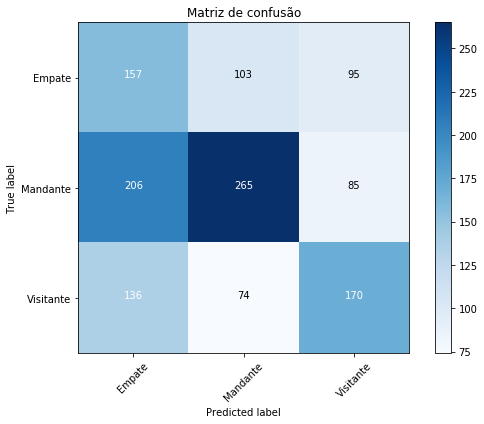

In [13]:
model = SVC(kernel='rbf', gamma='auto', class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

## RandomizedSearchCV

Função para determinar hiper parâmetros

In [14]:
from sklearn.model_selection import RandomizedSearchCV

tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5],
                 'C': [0.1, 1, 10, 50, 100, 500, 1000, 5000], 'class_weight':['balanced'],
                   'random_state':np.arange(0,50,1)}

modelSearchCV = RandomizedSearchCV(estimator=SVC(), 
                                 param_distributions=tuned_parameters,
                                 scoring=f1_scorer,
                                 cv=5,
                                 n_jobs=-1)

modelSearchCV.fit(X_train, y_train)

print('Best Score -> ', modelSearchCV.best_score_)
print('Best Params -> ', modelSearchCV.best_params_ )

Best Score ->  0.4737635835907182
Best Params ->  {'random_state': 17, 'kernel': 'rbf', 'gamma': 0.001, 'class_weight': 'balanced', 'C': 10}


              precision    recall  f1-score   support

      Empate       0.31      0.46      0.37       355
    Mandante       0.60      0.47      0.53       556
   Visitante       0.49      0.43      0.46       380

   micro avg       0.46      0.46      0.46      1291
   macro avg       0.47      0.45      0.45      1291
weighted avg       0.49      0.46      0.47      1291



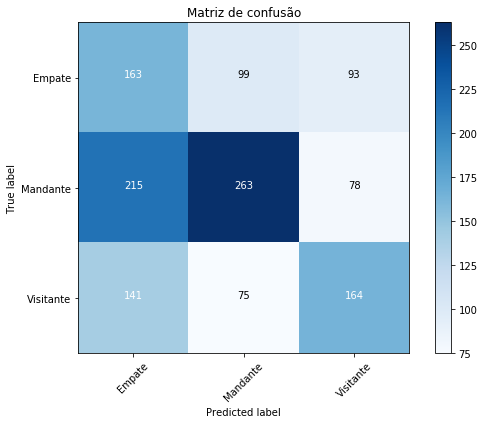

In [15]:
y_pred = modelSearchCV.predict(X_test)
plot_confusion_matrix(y_test, y_pred)